In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import shutil
import re
import pathlib

print(np.__version__)
print(tf.__version__)

1.19.2
2.5.0


# Data preperation

In [ ]:
# Create folders
datadirRaw = 'Video/Test C'
dirNames = ['0-25', '26-50', '51-75', '76-100']

for dirName in dirNames:
    if not os.path.exists(dirName):
        os.mkdir(datadirRaw + '_' + dirName)
        print("Directory " , dirName ,  " Created ")
    else:    
        print("Directory " , dirName ,  " already exists")

In [ ]:
# Move images into correct folder (based on names)
srcpath = 'Video/Test B'
dataset_size = 1815
quartile_1_directory = "data/Test C_0-25"
quartile_2_directory = "data/Test C_26-50"
quartile_3_directory = "data/Test C_51-75"
quartile_4_directory = "data/Test C_76-100"

fullpath = os.path.join

for dirname, dirnames, filenames in os.walk(srcpath):
    for filename in filenames:
        print(filename)
        source = fullpath(dirname, filename)
        cycle_number = re.search('_(.*).jpg', filename)

        if 0 <= int(cycle_number.group(1)) <= int(dataset_size/4):
            shutil.copy(source, fullpath(quartile_1_directory, filename))

        elif int(dataset_size/4) < int(cycle_number.group(1)) <= int(dataset_size/2):
            shutil.copy(source, fullpath(quartile_2_directory, filename))

        elif int(dataset_size/2) < int(cycle_number.group(1)) <= int(dataset_size/(4/3)):
            shutil.copy(source, fullpath(quartile_3_directory, filename))

        elif int(dataset_size/(4/3)) < int(cycle_number.group(1)) <= dataset_size:
            shutil.copy(source, fullpath(quartile_4_directory, filename))
        
        print('Moved file: ' + filename)

# Model & Training

In [ ]:
# Print a picture
data_dir = 'data' 
data_dir = pathlib.Path(data_dir)
ex_img = list(data_dir.glob('Test C_0-25/*'))
PIL.Image.open(str(ex_img[0]))

In [12]:
# Size of dataset
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

6004


In [107]:
batch_size = 32
img_height = 400
img_width = 300

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)  

Found 6012 files belonging to 4 classes.
Using 4810 files for training.
Found 6012 files belonging to 4 classes.
Using 1202 files for validation.


In [104]:
class_names = train_ds.class_names
print(class_names)

['Test C_0-25', 'Test C_26-50', 'Test C_51-75', 'Test C_76-100']


In [105]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

ResourceExhaustedError: OOM when allocating tensor with shape[1,500,500,3] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node resize/ResizeBilinear}}]] [Op:IteratorGetNext]

In [97]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [98]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

ResourceExhaustedError: Failed to allocate memory for the batch of component 0 [Op:IteratorGetNext]

In [ ]:
num_classes = 4

data_augmentation = keras.Sequential([layers.experimental.preprocessing.RandomFlip(input_shape=(img_height, img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.3),
    layers.experimental.preprocessing.RandomZoom(0.4),
  ]
)

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [84]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
151/151 [==============================] - 327s 2s/step - loss: 1.3840 - accuracy: 0.2796 - val_loss: 1.2920 - val_accuracy: 0.4967
Epoch 2/50
151/151 [==============================] - 322s 2s/step - loss: 1.2111 - accuracy: 0.3879 - val_loss: 1.3765 - val_accuracy: 0.3153
Epoch 3/50
151/151 [==============================] - 338s 2s/step - loss: 1.0491 - accuracy: 0.4983 - val_loss: 1.6417 - val_accuracy: 0.3303
Epoch 4/50
151/151 [==============================] - 321s 2s/step - loss: 0.9122 - accuracy: 0.5680 - val_loss: 1.2311 - val_accuracy: 0.3577
Epoch 5/50
151/151 [==============================] - 366s 2s/step - loss: 0.7924 - accuracy: 0.6306 - val_loss: 1.0791 - val_accuracy: 0.5150
Epoch 6/50
151/151 [==============================] - 317s 2s/step - loss: 0.7714 - accuracy: 0.6407 - val_loss: 0.8495 - val_accuracy: 0.6273
Epoch 7/50
151/151 [==============================] - 289s 2s/step - loss: 0.7216 - accuracy: 0.6593 - val_loss: 0.8705 - val_accuracy: 0.6048

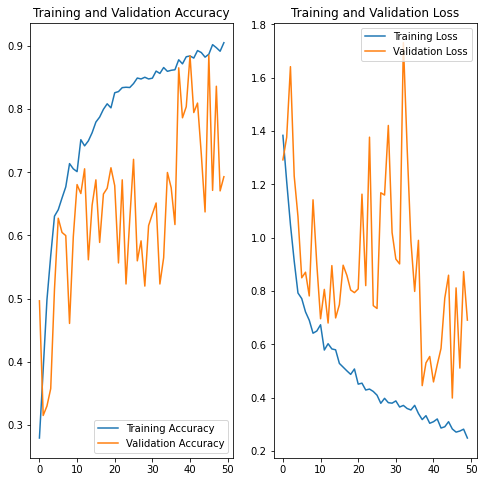

In [85]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [119]:
img = keras.preprocessing.image.load_img(
    'Video/test_data\q2.jpg', target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Test C_76-100 with a 100.00 percent confidence.
